In [ ]:
! pip install pymoo scipy pandas scikit-learn matplotlib

## Creating the Dataset for Training a Surrogate Model

### Objective
 The aim is to create a dataset to train a surrogate model that learns the relationship between the user preference vector (λ) and the local variability of optimal solutions, measured using the Frobenius norm of the estimated covariance matrix (∥Ĉ(λ)∥_F).

In practical terms, the goal is:

$$ \lambda = [\lambda_1, \lambda_2, \lambda_3] \longrightarrow \|\hat{C}(\lambda)\|_F $$

- **λ** represents a combination of preferences among objectives.
- **∥Ĉ(λ)∥_F** measures the structural variability of the optimal solutions associated with these preferences.

 The surrogate model will serve as a fast predictor, aiding the global algorithm to more efficiently explore the multi-objective space.



### Choice of the DTLZ2 benchmark problem
The choice of the benchmark problem **DTLZ2** is motivated by its widespread adoption in literature for testing multi-objective evolutionary algorithms (MOEAs), due to its regular Pareto front and easy scalability to multiple objectives [1] . Parameter selection (e.g., number of λ samples and generation method) follows established recommendations [2][3], facilitating easier evaluation based on known behavior of the DTLZ2 problem [4].

References:
[1] R. Cheng, Y. Jin, M. Olhofer and B. Sendhoff, "A Reference Vector Guided Evolutionary Algorithm for Many-Objective Optimization," in IEEE Transactions on Evolutionary Computation, vol. 20, no. 5, pp. 773-791, Oct. 2016, doi: 10.1109/TEVC.2016.2519378.
[2] Y. Yuan, H. Xu, B. Wang and X. Yao, "A New Dominance Relation-Based Evolutionary Algorithm for Many-Objective Optimization," in IEEE Transactions on Evolutionary Computation, vol. 20, no. 1, pp. 16-37, Feb. 2016, doi: 10.1109/TEVC.2015.2420112.
[3] H. Wu, Y. Jin, K. Gao, J. Ding and R. Cheng, "Surrogate-Assisted Evolutionary Multi-Objective Optimization of Medium-Scale Problems by Random Grouping and Sparse Gaussian Modeling," in IEEE Transactions on Emerging Topics in Computational Intelligence, vol. 8, no. 5, pp. 3263-3278, Oct. 2024, doi: 10.1109/TETCI.2024.3372378.
[4] Wang, X.; Jin, Y. Knowledge Transfer Based on Particle Filters for Multi-Objective Optimization. Math. Comput. Appl. 2023, 28, 14. https://doi.org/10.3390/mca28010014


In [71]:
from pymoo.problems.many import DTLZ2
import numpy as np

# Problem Definition
n_obj = 3
k = 20
n_vars = n_obj + k - 1

problem = DTLZ2(n_var=n_vars, n_obj=n_obj)

In [114]:
from scipy.optimize import minimize
import pandas as pd
from sklearn.preprocessing import normalize

# Step 1: Generation of λ vectors
# Random user preference vectors (λ), each with length 3, are generated. Each λ vector sums to 1, representing normalized preferences among different objectives

n_lambda = 450
lambda_vectors = np.random.rand(n_lambda, n_obj)
lambda_vectors = normalize(lambda_vectors, norm='l1', axis=1)

# Define scalarized objective function based on λ preferences
def scalarized_objective(x, lam):
    f = problem.evaluate(np.array([x]))[0]
    return np.dot(lam, f)

# Find optimal solutions x* for each λ preference
x_star_list = []

for lam in lambda_vectors:
    res = minimize(scalarized_objective,
                   x0=np.full(n_vars, 0.5),
                   args=(lam,),
                   method='L-BFGS-B',
                   bounds=[(0.0, 1.0)] * n_vars)
    x_star_list.append(res.x)
x_star_array = np.array(x_star_list)


In [115]:
from sklearn.preprocessing import StandardScaler

# Step 2: Covariance matrix calculation and its Frobenius norm
# For each λ vector, results from the scalarized multi-objective problem are simulated or computed. Then, the covariance matrix of local optimal solutions and its Frobenius norm (indicating local variability) are estimated.

window_size = 10
C_matrices = []
frob_norms = []
variances = []
P_vectors = []

for i in range(n_lambda):
    start = max(0, i - window_size // 2)
    end = min(n_lambda, i + window_size // 2 + 1)
    X_local = x_star_array[start:end]

    scaler = StandardScaler()
    X_local = scaler.fit_transform(X_local)

    C = np.cov(X_local.T)
    C += np.eye(C.shape[0]) * 1e-8  # regularization
    C_matrices.append(C)

    frob = np.linalg.norm(C, ord='fro')
    frob_norms.append(frob)

    var = np.var(X_local, axis=0)
    variances.append(var)

    P = np.linalg.cholesky(C)
    P_vectors.append(P[np.tril_indices_from(P)])

# Step 3: Creating the final dataset
# Combine generated λ vectors and corresponding Frobenius norms into a DataFrame for training the surrogate model.

data_dict = {f"lambda_{i+1}": lambda_vectors[:, i] for i in range(n_obj)}
data_dict["frob_norm"] = frob_norms
for i in range(n_vars):
    data_dict[f"x_star_{i+1}"] = x_star_array[:, i]
    data_dict[f"var_x_star_{i+1}"] = [v[i] for v in variances]
for i in range(len(P_vectors[0])):
    data_dict[f"P_vec_{i+1}"] = [p[i] for p in P_vectors]
data_dict["source"] = ["original"] * len(lambda_vectors)


In [116]:
# Generate additional λ samples close to the simplex borders for extended coverage
n_new_samples = 50
lambda_borders = []
for i in range(3):
    lam = np.random.rand(n_new_samples, 3)
    lam[:, i] = np.random.uniform(0.9, 1.0, n_new_samples)
    lambda_borders.append(normalize(lam, norm='l1', axis=1))
lambda_borders = np.vstack(lambda_borders)

existing_lambdas = lambda_vectors
filtered_lambda_borders = np.array([lam for lam in lambda_borders if not np.any(np.all(np.abs(existing_lambdas - lam) < 1e-5, axis=1))])

new_frob_norms, new_x_star, new_variances, new_P_vectors = [], [], [], []
for lam in filtered_lambda_borders:
    res = minimize(scalarized_objective, x0=np.full(n_vars, 0.5), args=(lam,), method='L-BFGS-B', bounds=[(0.0, 1.0)] * n_vars)
    x_opt = res.x
    new_x_star.append(x_opt)
    if len(new_x_star) >= 2:
        X_local = StandardScaler().fit_transform(np.array(new_x_star[-window_size:]))
        C = np.cov(X_local.T) + np.eye(n_vars) * 1e-8
        new_frob_norms.append(np.linalg.norm(C, ord='fro'))
        new_variances.append(np.var(X_local, axis=0))
        P = np.linalg.cholesky(C)
        new_P_vectors.append(P[np.tril_indices_from(P)])
    else:
        new_frob_norms.append(np.nan)
        new_variances.append(np.full(n_vars, np.nan))
        new_P_vectors.append(np.full((n_vars * (n_vars + 1)) // 2, np.nan))

In [117]:
# Step 4: Merge with existing dataset

new_data_dict = {f"lambda_{i+1}": filtered_lambda_borders[:, i] for i in range(3)}
new_data_dict["frob_norm"] = new_frob_norms
for i in range(n_vars):
    new_data_dict[f"x_star_{i+1}"] = [x[i] for x in new_x_star]
    new_data_dict[f"var_x_star_{i+1}"] = [v[i] for v in new_variances]
for i in range(len(new_P_vectors[0])):
    new_data_dict[f"P_vec_{i+1}"] = [p[i] for p in new_P_vectors]
new_data_dict["source"] = ["border"] * len(filtered_lambda_borders)

new_df = pd.DataFrame(new_data_dict)
dataset = pd.DataFrame(data_dict)
updated_dataset = pd.concat([dataset, new_df], ignore_index=True)
updated_dataset.to_csv("dtlz2_surrogate_dataset_extended_updated.csv", index=False)


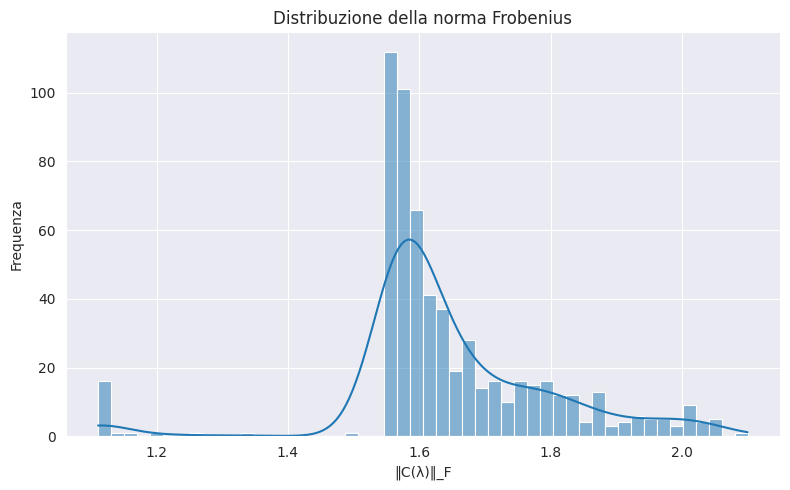

C:\Users\aless\AppData\Local\Temp\ipykernel_15004\4223102293.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = updated_dataset.pivot_table(index="lambda_1_bin", columns="lambda_2_bin", values="frob_norm", aggfunc="mean")


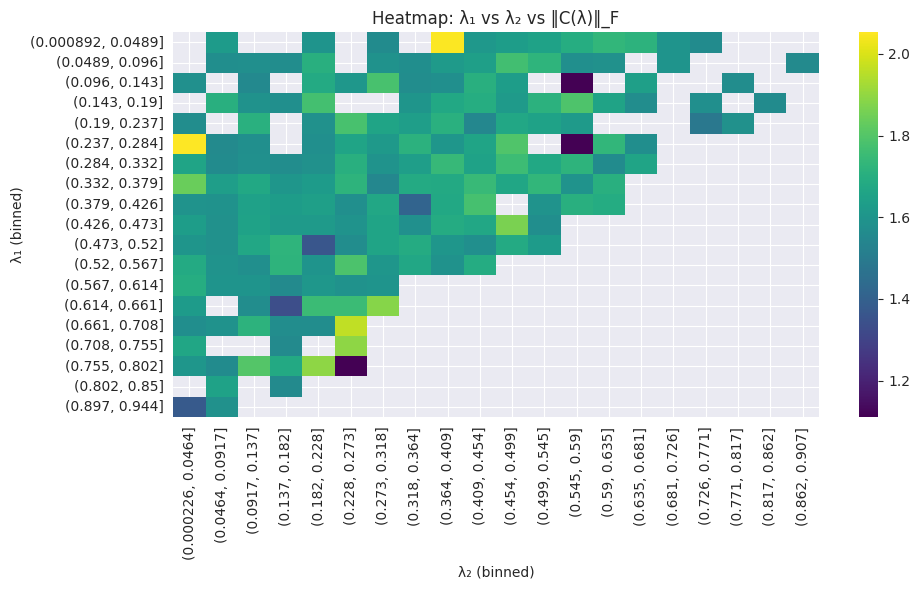

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of Frobenius norm
plt.figure(figsize=(8, 5))
sns.histplot(updated_dataset["frob_norm"], bins=50, kde=True)
plt.title("Frobenius Norm Distribution")
plt.xlabel("‖C(λ)‖_F")
plt.ylabel("Frequenza")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot heatmap: λ₁ vs λ₂ vs Frobenius norm
updated_dataset["lambda_1_bin"] = pd.cut(updated_dataset["lambda_1"], bins=20)
updated_dataset["lambda_2_bin"] = pd.cut(updated_dataset["lambda_2"], bins=20)
heatmap_data = updated_dataset.pivot_table(index="lambda_1_bin", columns="lambda_2_bin", values="frob_norm", aggfunc="mean")

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="viridis")
plt.title("Heatmap: λ₁ vs λ₂ vs ‖C(λ)‖_F")
plt.xlabel("λ₂ (binned)")
plt.ylabel("λ₁ (binned)")
plt.tight_layout()
plt.show()
